In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

from openpathsampling.analysis.tis_analysis import TISTransition
from openpathsampling.analysis.tis_analysis import sampleset_sample_generator

storage = paths.storage.Storage("_toy_retis.nc", mode="r")

In [2]:
print len(storage.samplesets)

201


In [3]:
%%time
storage.samples.cache_all()
storage.samplesets.cache_all()
storage.pathmovechanges.cache_all()
storage.steps.cache_all()
map(lambda x : x.cache_all(storage), storage.cvs)

CPU times: user 850 ms, sys: 52.6 ms, total: 903 ms
Wall time: 909 ms


In [4]:
retis = storage.transitions.load(0)
retis.ensemble_histogram_info['pathlength'].hist_args = { 'bin_width' : 5, 'bin_range' : (0, 150) }
retis.ensemble_histogram_info['max_lambda'].hist_args = { 'bin_width' : 0.02, 'bin_range' : (-0.35, 0.35) }

In [5]:
%%time
retis.rate(storage)

CPU times: user 452 ms, sys: 45.6 ms, total: 497 ms
Wall time: 1.99 s


0.0025096744644016711

In [6]:
%%time
retis.move_summary(storage)
print

pathreversal ran 26.368159204% of the cycles with acceptance 28/53 (0.528301886792) 
shooting ran 46.2686567164% of the cycles with acceptance 69/93 (0.741935483871) 
minus ran 0.995024875622% of the cycles with acceptance 1/2 (0.5) 
repex ran 25.8706467662% of the cycles with acceptance 36/52 (0.692307692308) 

CPU times: user 59.3 ms, sys: 6.73 ms, total: 66 ms
Wall time: 76.3 ms


In [7]:
%%time
retis.move_summary(storage, 'shooting')
print

OneWayShootingMover I'face 3 ran 7.46268656716% of the cycles with acceptance 8/15 (0.533333333333) 
OneWayShootingMover I'face 5 ran 9.45273631841% of the cycles with acceptance 15/19 (0.789473684211) 
OneWayShootingMover I'face 2 ran 6.96517412935% of the cycles with acceptance 12/14 (0.857142857143) 
OneWayShootingMover I'face 4 ran 8.45771144279% of the cycles with acceptance 11/17 (0.647058823529) 
OneWayShootingMover I'face 0 ran 6.96517412935% of the cycles with acceptance 11/14 (0.785714285714) 
OneWayShootingMover I'face 1 ran 6.96517412935% of the cycles with acceptance 12/14 (0.857142857143) 

CPU times: user 577 µs, sys: 1 µs, total: 578 µs
Wall time: 586 µs


In [8]:
def first_n(storage, n, trajid):
    sample_iter = sampleset_sample_generator(storage)
    first = []
    old=None
    for s in sample_iter:
        if s.replica == trajid:
            if s != old:
                first.append(s)
            old = s
        if len(first) == n:
            break
    return first

In [9]:
first40 = first_n(storage, 40, trajid=4)

In [10]:
%%time
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG

tree = PathTreeBuilder(storage)        
tree.rejected = True
tree.from_samples(first40)
view = tree.renderer
view.zoom = 0.8
view.scale_y = 24
view.scale_x = 14
view.font_size = 0.35

CPU times: user 1.54 s, sys: 239 ms, total: 1.78 s
Wall time: 6.6 s


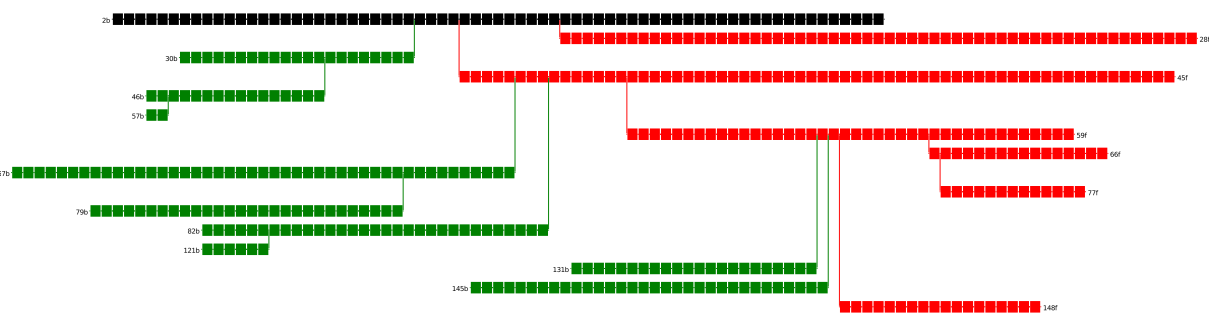

In [11]:
SVG(view.to_svg())

In [12]:
prev = first40[0].trajectory
decorrelated = [prev]
for s in first40:
    if not paths.Trajectory.is_correlated(s.trajectory, prev):
        decorrelated.append(s.trajectory)
        prev = s.trajectory
print "From these samples we have " + str(len(decorrelated)) + " decorrelated trajectories."

From these samples we have 2 decorrelated trajectories.


In [13]:
retis.ensemble_histogram_info['pathlength'].hist_args = { 'bin_width' : 5, 'bin_range' : (0, 150) }
retis.ensemble_histogram_info['max_lambda'].hist_args = { 'bin_width' : 0.02, 'bin_range' : (-0.35, 0.35) }

In [14]:
%%time
retis.all_statistics(storage=storage, weights=None, force=True)

CPU times: user 155 ms, sys: 21.4 ms, total: 176 ms
Wall time: 175 ms


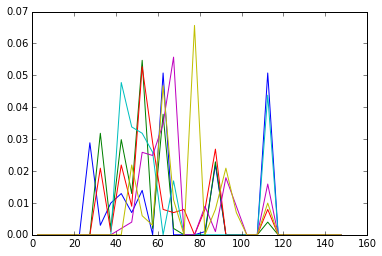

In [15]:
for ens in retis.ensembles:
    myhist = retis.histograms['pathlength'][ens]
    normalized = myhist.normalized()
    plt.plot(normalized.x, normalized)

In [16]:
np.log(myhist.reverse_cumulative())

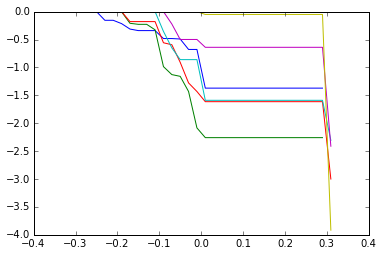

In [17]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    reverse_cumulative = myhist.reverse_cumulative()
    plt.plot(reverse_cumulative.x, np.log(reverse_cumulative))

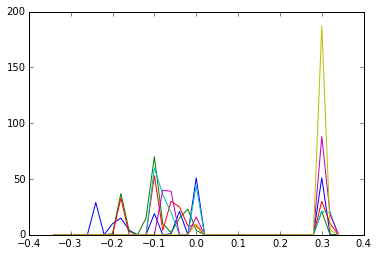

In [18]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]()
    plt.plot(myhist.x, myhist)

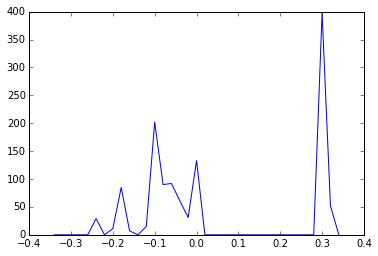

In [19]:
# TODO: add a histogram.sum_hist() function to add several histograms together
from operator import add
total_sampling = np.zeros(len(retis.histograms['max_lambda'][retis.ensembles[0]]()))
for ens in retis.ensembles:
    total_sampling = map(add, total_sampling, retis.histograms['max_lambda'][ens]())
plt.plot(myhist.x, total_sampling);

In [20]:
from toy_plot_helpers import ToyPlot
plot = ToyPlot()
plot.add_pes(storage.engines.load(0).pes)

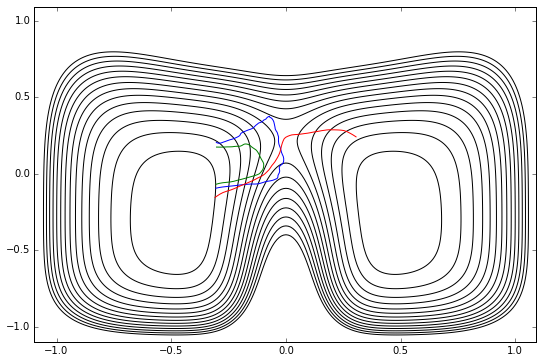

In [21]:
ens0_traj = [s.trajectory for s in storage.samples if s.ensemble == retis.ensembles[0]]
plt.contour(plot.X, plot.Y, plot._pes, levels=np.arange(0.0, 1.5, 0.1), colors='k')
for mytraj in ens0_traj[slice(None,None,15)]:
    plt.plot(mytraj.coordinates()[:,0,0], mytraj.coordinates()[:,0,1])

In [22]:
wham = retis.total_crossing_probability(method="wham")

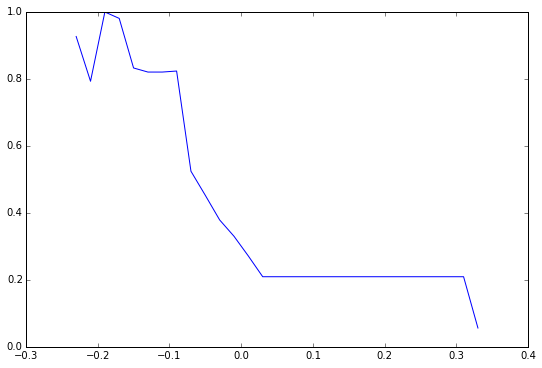

In [23]:
plt.plot(wham.x, wham);

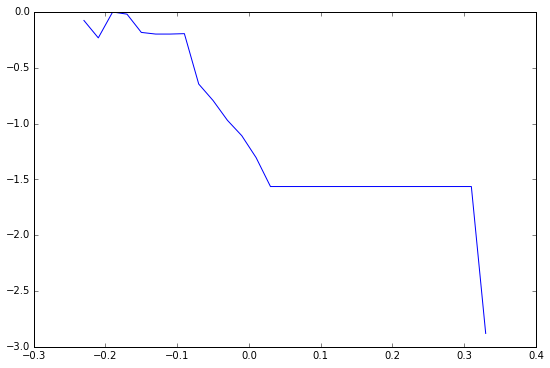

In [24]:
plt.plot(wham.x, np.log(wham));

In [25]:
%%time
#retis.rate(storage=storage)
# TODO: conditional_transition_probability, minus_flux, rate
retis.conditional_transition_probability(storage, retis.ensembles[-1])

CPU times: user 17.1 ms, sys: 3.28 ms, total: 20.3 ms
Wall time: 18.2 ms


0.9502487562189055

In [26]:
retis.minus_move_flux(storage)

0.0080000000000000002

In [27]:
print retis._flux, retis.tcp(-0.05), retis.ctp[retis.ensembles[-1]]

0.008 0.45243529201 0.950248756219
